ler mais sobre partição para explicar como tem muito shuffle no repartition se só tem um nó

# Tecnologias de Dados
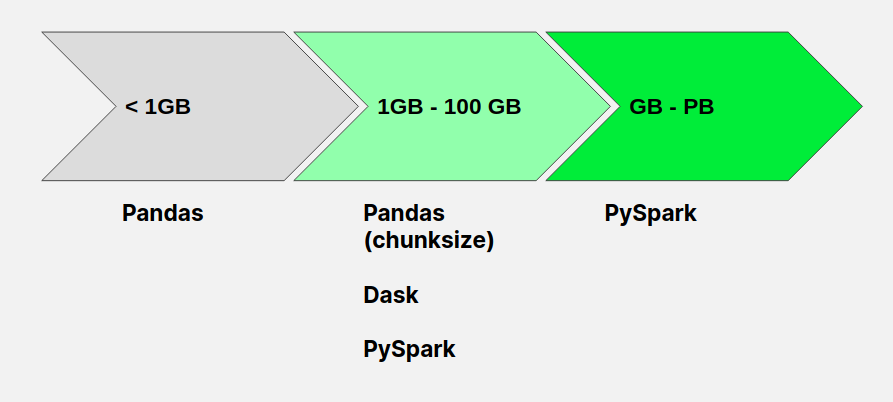

# Arquitetura Spark

Utiliza processamento distribuido para atingir performance, particionando os dados e alocando eles em memória sitribuidos entre os nós.\
Os componentes macro de uma aplicação spark são:

- Driver
    - Traduzem o código em Spark jobs
    - Criado no mesmo nó que o Application Master
- Application Master
    - Conversa com o Workers, Resource Manager e monitora tasks
- Spark Context
    - Criado pelo Spark Session, junto com o Spark Config
    - Coração do aplicação Spark
    - Utilizado para ciar RDDs
- Cluster Resource Manager (nesse exemplo é o YARN)
    - Controla e reserva containers a mando do Application Master
- Executors 
    - Responsável por executar as tasks no Worker Node

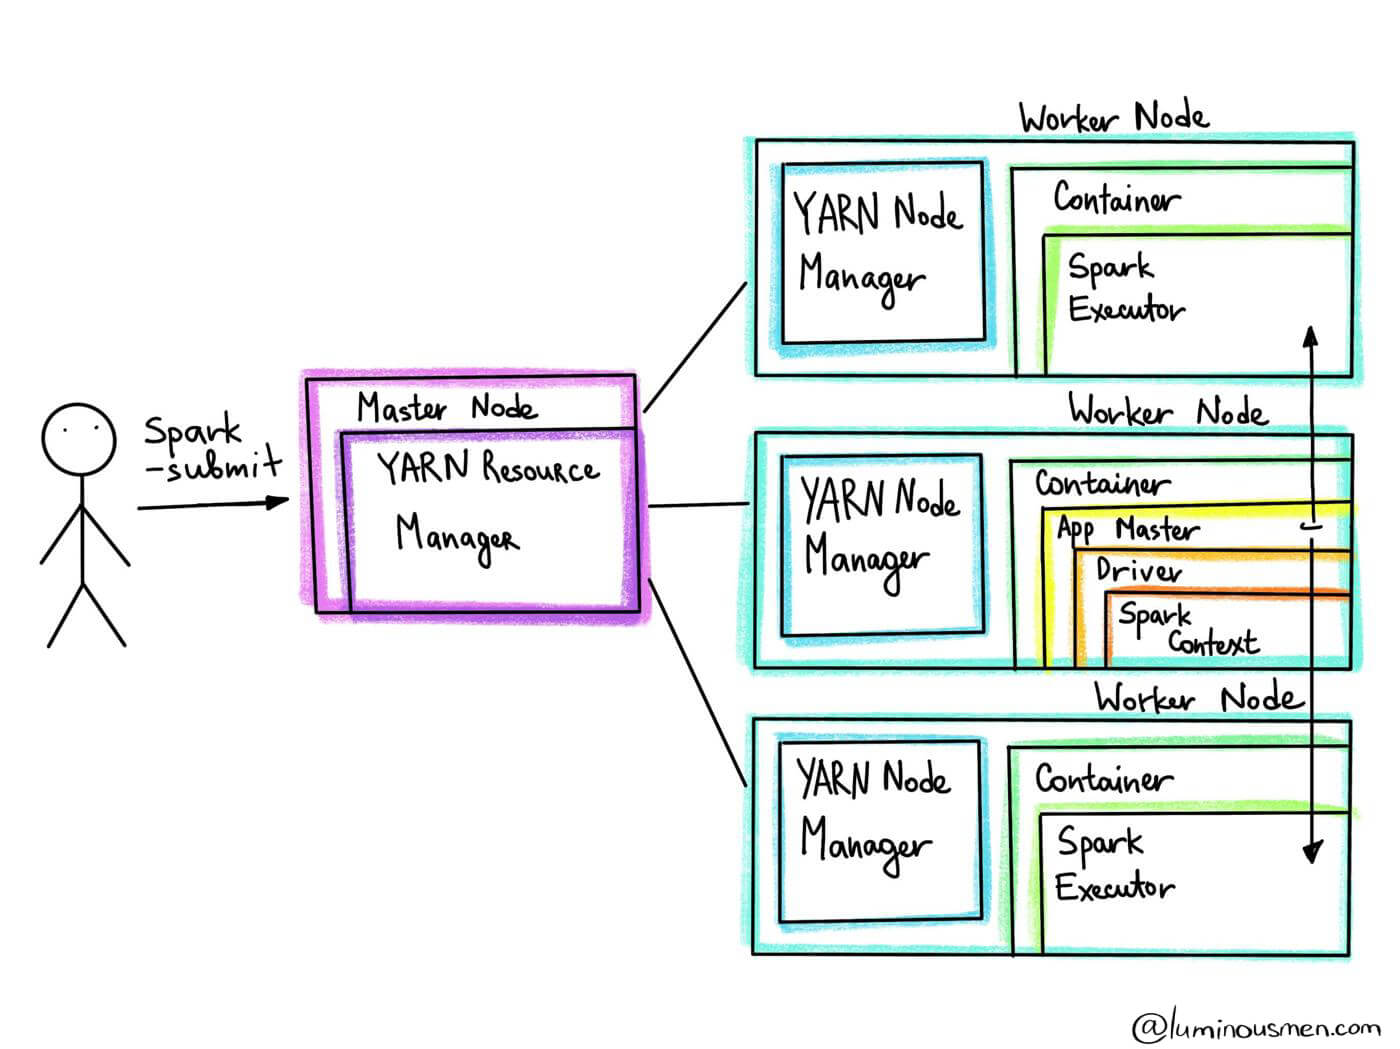
---
Referência: https://luminousmen.com/post/spark-anatomy-of-spark-application \
Comparação map reduce e spark: https://www.infoq.com/br/articles/mapreduce-vs-spark/

In [1]:
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window

In [2]:
spark = (SparkSession.builder 
        .master("local[*]") 
        .appName("workshop_spark")
        .getOrCreate())

## Spark UI

Monitoramento da aplicação Spark, funciona através de lisseners. Habilitado por padrão, mas pode ser desabilitado através de configuração.

Visualização de DAGs, timeline, jobs, stages e tasks.

---
Artigo Databricks: https://databricks.com/blog/2015/06/22/understanding-your-spark-application-through-visualization.html \
Documentação: https://spark.apache.org/docs/3.0.0-preview2/web-ui.html

In [3]:
spark

Inicialmente _Event Timeline_ está vazio, já que não rodamos nenhum job nessa Session
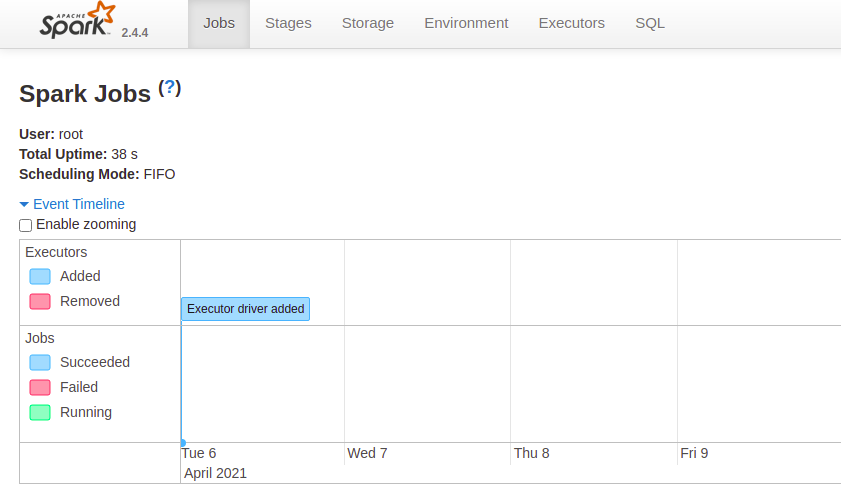

Aba Environment mostra as propriedades do cluster spark, propriedades do sistema, entre outros.

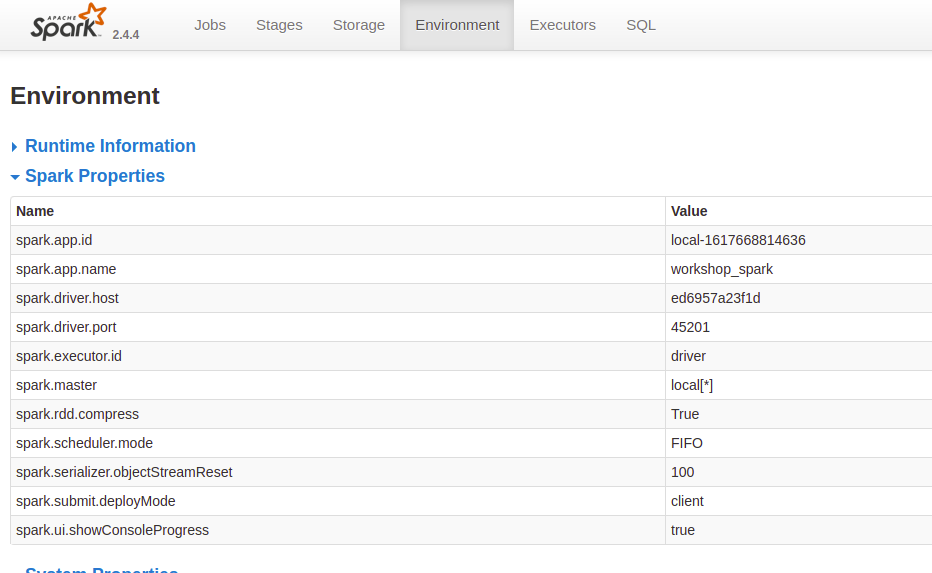

As demais abase, veremos ao decorrer do treinamento.

# Leitura de Dados
---
Leitura de csv: https://sparkbyexamples.com/spark/spark-read-csv-file-into-dataframe/

In [4]:
municipios = spark.read.option("header", True).csv("../../data/municipios.csv") #Job 0
populacao = spark.read.option("header", True).csv("../../data/populacao_municipios.csv") #Job 1
nomes = spark.read.option("header", True).csv("../../data/nomes_municipios.csv") #Job 2

# Detalhando Spark Jobs 

Depois dessa execução, cada leitura de arquivo inicia um job, todos concluídos com sucesso

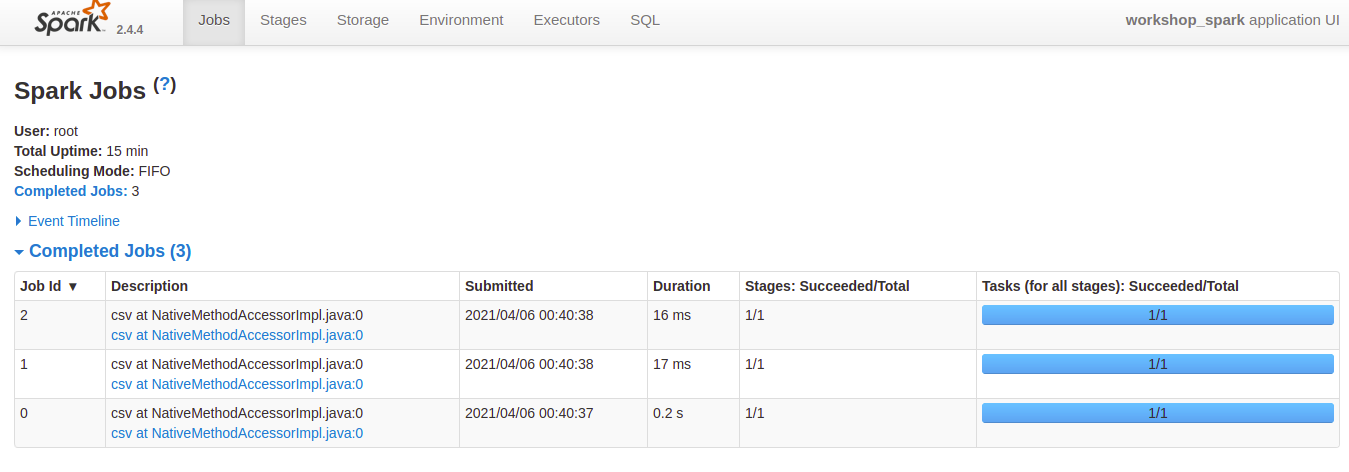

Jobs > Stages > Tasks

## Job

Analisando um job específico, temos os Stages que formam aquele job. O job é um conjunto de Stages, inicializados por uma ação.

As caixas azuis são Spark operation e os pontinhos são RDDs (resilient distributed dataset) - coleção de elementos particionados nos nós do cluster criados a partir dessas operações.

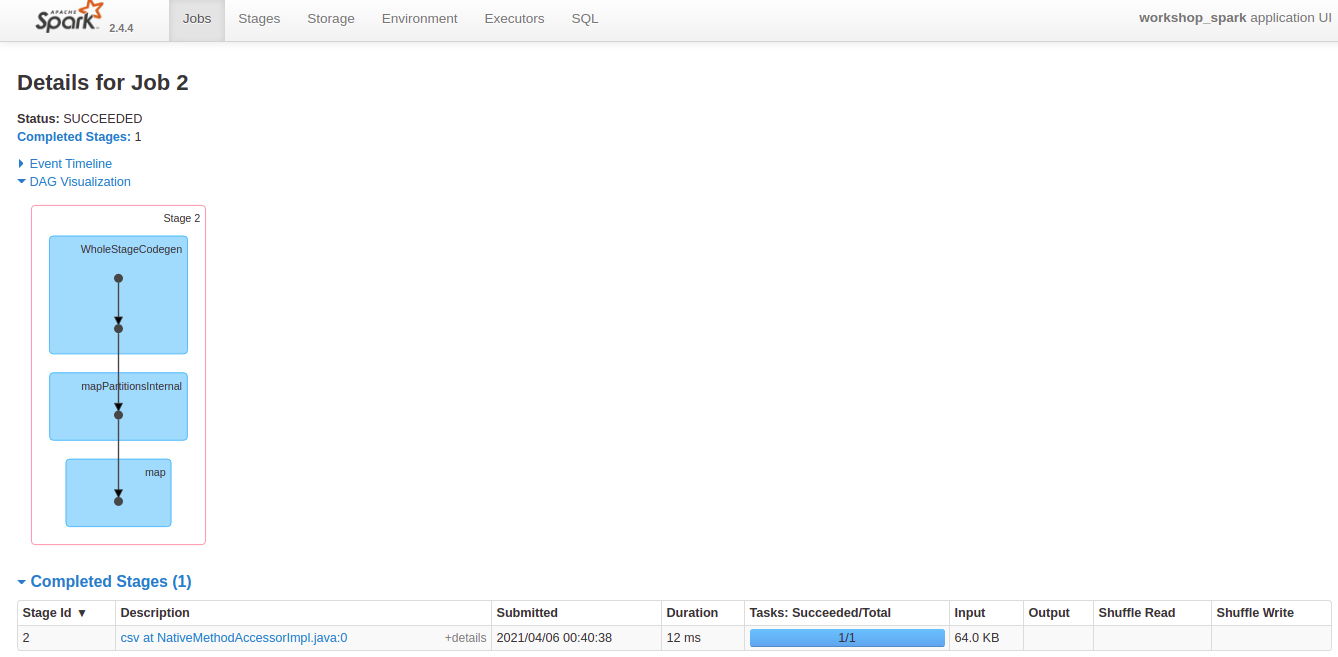

## Stage

Conjunto de operações que executam em várias partições

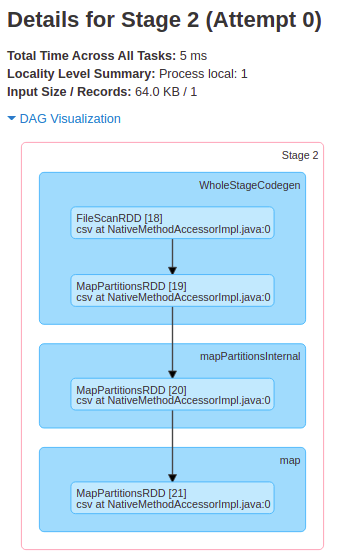

Também é interessante observar o Event Timeline para analisar os tipos de operações necessárias.

## Tasks

Operação única aplicada a uma única partição de dados.

Na UI, outras informações como onde as tasks foram executadas e tempo de execução são mostrados.

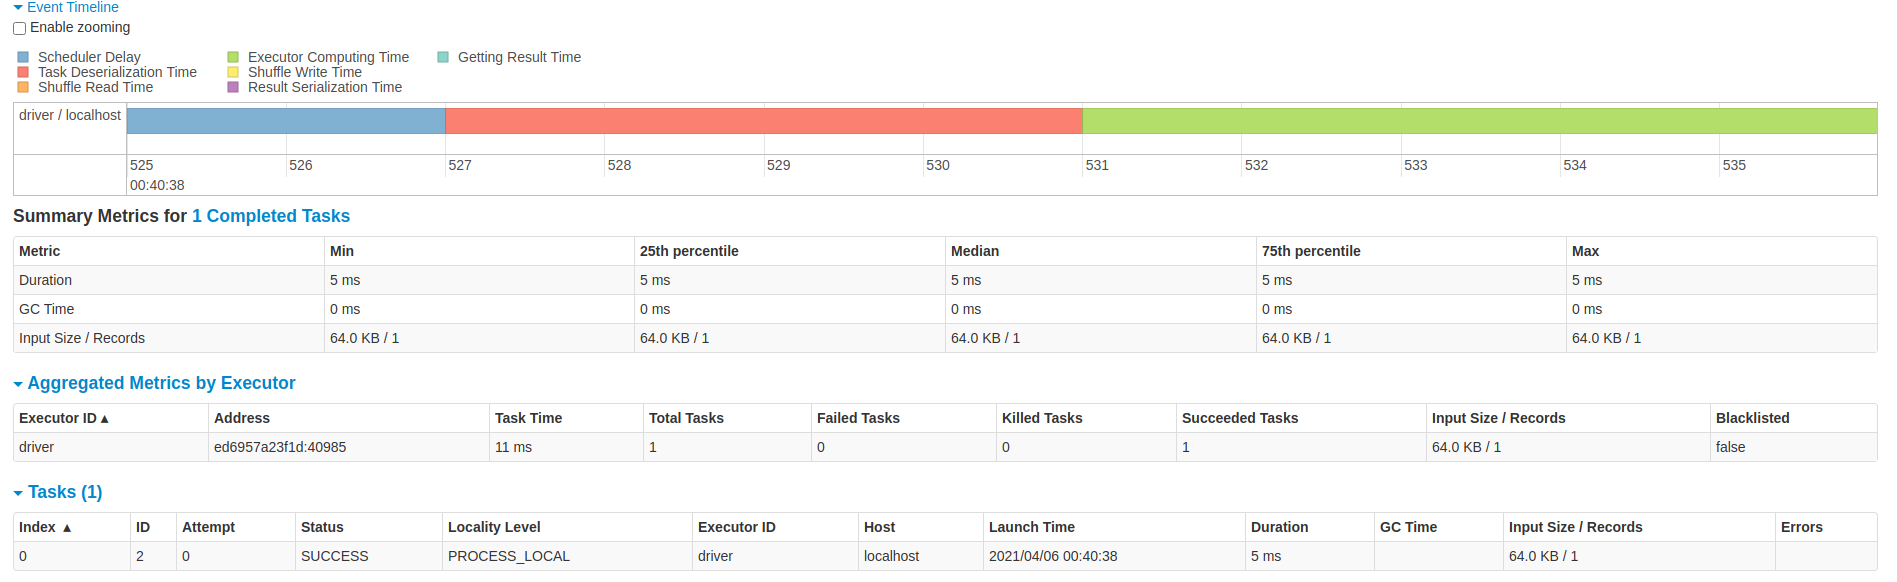

# Conhecendo os dados
---
Exemplo mais extenso de exploração de dados: https://www.kaggle.com/tientd95/advanced-pyspark-for-exploratory-data-analysis

In [5]:
populacao.limit(3).toPandas() #Job 3

,id_municipio,ano,populacao
0,1100015,1991,31981
1,1100015,1992,34768
2,1100015,1993,37036


In [6]:
print(nomes.dtypes)
# lê tudo como string, por default
nomes.describe().show() #Job 4

[('id_municipio', 'string'), ('nome', 'string'), ('qtde_nascimentos_ate_2010', 'string')]
+-------+-----------------+------+-------------------------+
|summary|     id_municipio|  nome|qtde_nascimentos_ate_2010|
+-------+-----------------+------+-------------------------+
|  count|            16000| 16000|                    16000|
|   mean|   1275691.432125|  null|                237.01825|
| stddev|133120.7010056176|  null|       1061.9399168814268|
|    min|          1100015|Abdias|                      100|
|    max|          1500800|Zumira|                      998|
+-------+-----------------+------+-------------------------+



In [7]:
print(municipios.count()) #Job 5
municipios.columns

5570


['id_municipio',
 'id_municipio_6',
 'id_municipio_TSE',
 'id_municipio_RF',
 'id_municipio_BCB',
 'municipio',
 'capital_estado',
 'id_comarca',
 'id_regiao_saude',
 'regiao_saude',
 'id_regiao_imediata',
 'regiao_imediata',
 'id_regiao_intermediaria',
 'regiao_intermediaria',
 'id_microrregiao',
 'microrregiao',
 'id_mesorregiao',
 'mesorregiao',
 'id_estado',
 'estado_abrev',
 'estado',
 'regiao',
 'existia_1991',
 'existia_2000',
 'existia_2010']

In [8]:
#filtrar populacao por ano 2010
populacao_f = populacao.where(col("ano") == 2010) # alias do filter

municipios_f = (municipios
                .select("id_municipio", "municipio", "capital_estado", "estado", "regiao"))

#outra forma de usar o select: 
#municipios_f = (municipios
#                .select("id_municipio", F.upper(col("municipio")).alias("municipio"), "capital_estado", "regiao")
#               )

nomes = nomes.withColumn("qtde_nascimentos_ate_2010", nomes["qtde_nascimentos_ate_2010"].cast(IntegerType()))

## Plano de Execução
Lineage dos dados

### Transformação
Operações de transformações criam um novo DataFrame a partir de um Dataframe base.
São cahamdas "lazy" por não ser executadas naquele momento (ficam no plano de ação)
Tipos de transformações:
    - narrow: não precisam de dados de outras partições. Ex.: map
    - wide: precisam de shuffle (ler dados de outras partições) e criam um outro stage Ex.: groupby, join

### Ação
Operações que precisam avaliar o dataframe como um todo (show, count, write).
Nesse momento spark executa o plano de ação

----
Artigo "Plano de execução para leigos": https://ichi.pro/pt/planos-de-consulta-do-spark-para-leigos-122282881757510

In [9]:
populacao.where(col("ano") == 1991)

DataFrame[id_municipio: string, ano: string, populacao: string]

A operação de filtragem acima não inicializa nenhum job
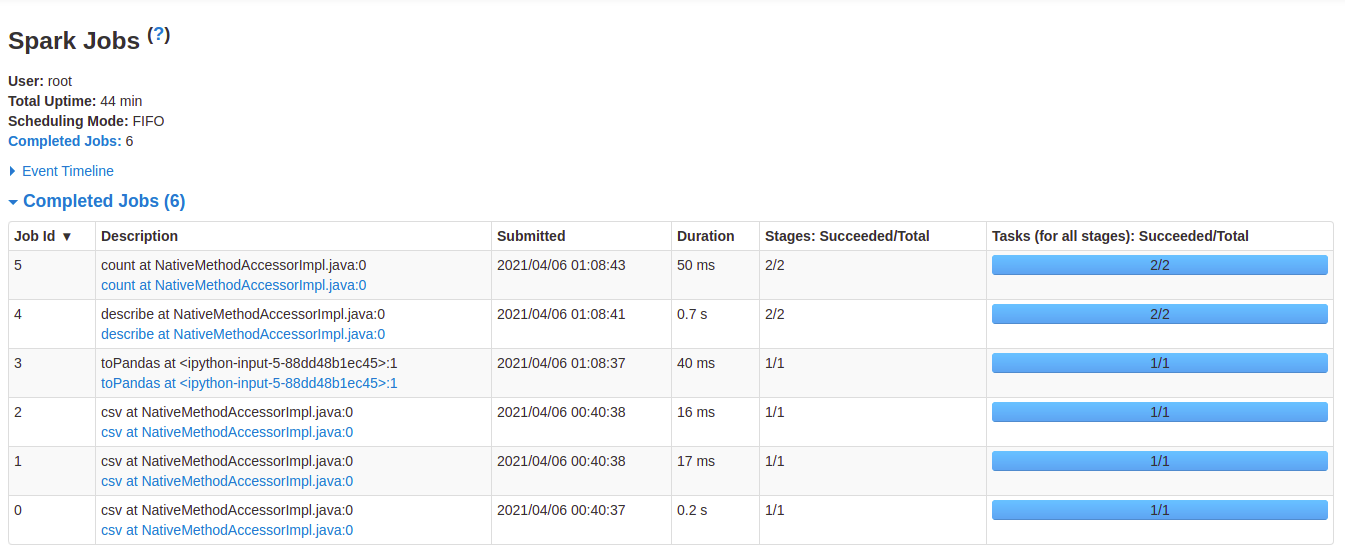

In [10]:
populacao_f.explain()
# odem de execução é de baixo pra cima
# project é um operador que é criado depois de algum tipo de projeção implicata ou explicita 
#  pode aparecer no plano de execução depois do where, por exemplo

== Physical Plan ==
*(1) Project [id_municipio#70, ano#71, populacao#72]
+- *(1) Filter (isnotnull(ano#71) && (cast(ano#71 as int) = 2010))
   +- *(1) FileScan csv [id_municipio#70,ano#71,populacao#72] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/opt/dna-spark/data/populacao_municipios.csv], PartitionFilters: [], PushedFilters: [IsNotNull(ano)], ReadSchema: struct<id_municipio:string,ano:string,populacao:string>


In [11]:
populacao_f.show(2)  #Job 6

+------------+----+---------+
|id_municipio| ano|populacao|
+------------+----+---------+
|     1100015|2010|    24392|
|     1100023|2010|    90353|
+------------+----+---------+
only showing top 2 rows



Com a operação de show (ação!) o job 6 é criado 
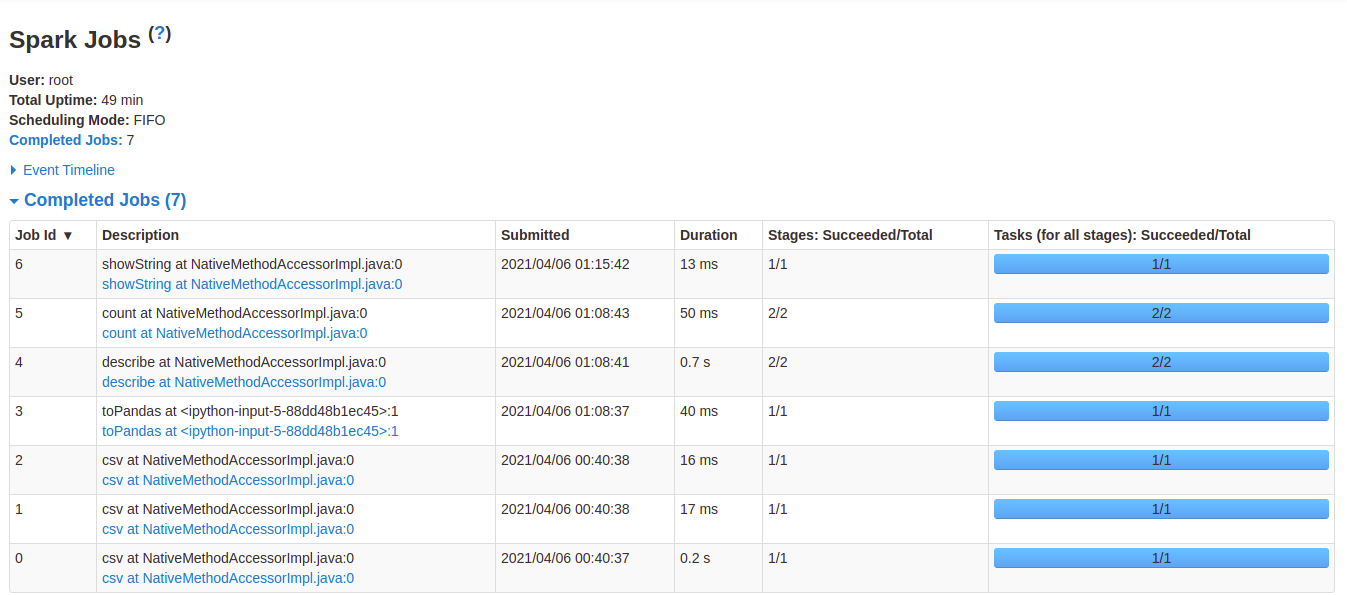

## Join

In [13]:
df = (nomes.join(municipios_f, "id_municipio", how="left")
           .join(populacao_f, "id_municipio", how="left")
     )

In [14]:
df.limit(5).toPandas() # Job 7, Job 8, Job 9

,id_municipio,nome,qtde_nascimentos_ate_2010,municipio,capital_estado,estado,regiao,ano,populacao
0,1100015,Ademir,46,Alta Floresta D'Oeste,0,Rondônia,Norte,2010,24392
1,1100015,Adriana,60,Alta Floresta D'Oeste,0,Rondônia,Norte,2010,24392
2,1100015,Aline,77,Alta Floresta D'Oeste,0,Rondônia,Norte,2010,24392
3,1100015,Amanda,51,Alta Floresta D'Oeste,0,Rondônia,Norte,2010,24392
4,1100015,Ana,300,Alta Floresta D'Oeste,0,Rondônia,Norte,2010,24392


## Broadcast
Broadcast faz com que os valores sejam salvos em memória (se não tiver memporia suficiente, vai pro disco), para todos os executores que irão precisar desses dados.
Pode ser utilizado para joins entre tabelas grandes com tabelas relativamente pequenas.

Essa estratégia de join já é utilizada quando o tamanho de uma das tabelas fica aboixo da configuração spark.sql.autoBroadcastJoinThreshold

A função é lazy

---
Exemplos: https://jaceklaskowski.gitbooks.io/mastering-spark-sql/content/spark-sql-joins-broadcast.html \
Hint: https://jaceklaskowski.gitbooks.io/mastering-spark-sql/content/spark-sql-hint-framework.html

In [18]:
df.explain()
# Esse join usou essa estratégia BroadcastHashJoin
# Dá pra identificar os 3 jobs no plano

== Physical Plan ==
*(3) Project [id_municipio#86, nome#87, qtde_nascimentos_ate_2010#325, municipio#15, capital_estado#16, estado#30, regiao#31, ano#71, populacao#72]
+- *(3) BroadcastHashJoin [id_municipio#86], [id_municipio#70], LeftOuter, BuildRight
   :- *(3) Project [id_municipio#86, nome#87, qtde_nascimentos_ate_2010#325, municipio#15, capital_estado#16, estado#30, regiao#31]
   :  +- *(3) BroadcastHashJoin [id_municipio#86], [id_municipio#10], LeftOuter, BuildRight
   :     :- *(3) Project [id_municipio#86, nome#87, cast(qtde_nascimentos_ate_2010#88 as int) AS qtde_nascimentos_ate_2010#325]
   :     :  +- *(3) FileScan csv [id_municipio#86,nome#87,qtde_nascimentos_ate_2010#88] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/opt/dna-spark/data/nomes_municipios.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<id_municipio:string,nome:string,qtde_nascimentos_ate_2010:string>
   :     +- BroadcastExchange HashedRelationBroadcastMode(List(input[0, str

In [ ]:
# Pode ser especificado de duas formas
df_b = nomes.join(broadcast(municipios_f), "id_municipio", how="left")
df_b = nomes.join(municipios_f.hint("broadcast"), "id_municipio", how="left")

## Particionamento

Particionamento é a principal unidade de paralelismo no Apache Spark. Cada partição é enviada para workers.

A importância de particionar bem:
- Partição de menos: Não utiliza bem os recursos do cluster
- Partições de mais: Introduz overhead no gerenciamento de muitas partições

Como fazer?:
- coalesce() para diminuir o número de partições.
- repartition() para aumentar.

Caso de particionamento por chave de negócio
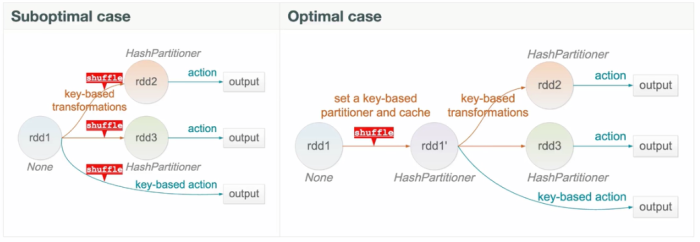

---
Entendendo partições: https://luminousmen.com/post/spark-partitions \
Entendendo partições2: https://techmagie.wordpress.com/2015/12/19/understanding-spark-partitioning/ \
Tunning: https://luminousmen.com/post/spark-tips-partition-tuning

In [19]:
# por padrão o spark faz particionamento
print(f'Particionamento padrão: {df.rdd.getNumPartitions()}')

# nomes mais comuns
df_g = (df.select("nome", "qtde_nascimentos_ate_2010")
  .groupby("nome")
  .agg( sum("qtde_nascimentos_ate_2010")
        .alias("qtde_nascimentos_ate_2010"))
  .sort(col("qtde_nascimentos_ate_2010").desc())
       )

print(f'Particionamento depois do agrupamento: {df_g.rdd.getNumPartitions()}')
df_g.limit(5).toPandas()

Particionamento padrão: 1
Particionamento depois do agrupamento: 170


,nome,qtde_nascimentos_ate_2010
0,Maria,385816
1,Jose,163729
2,Ana,99245
3,Antonio,94619
4,Francisco,93829


Analisando o ultimo stage do job que faz o agrupamento, podemos ver as diversas tasks, uma para cada partição, representadas pelas barras de eventos
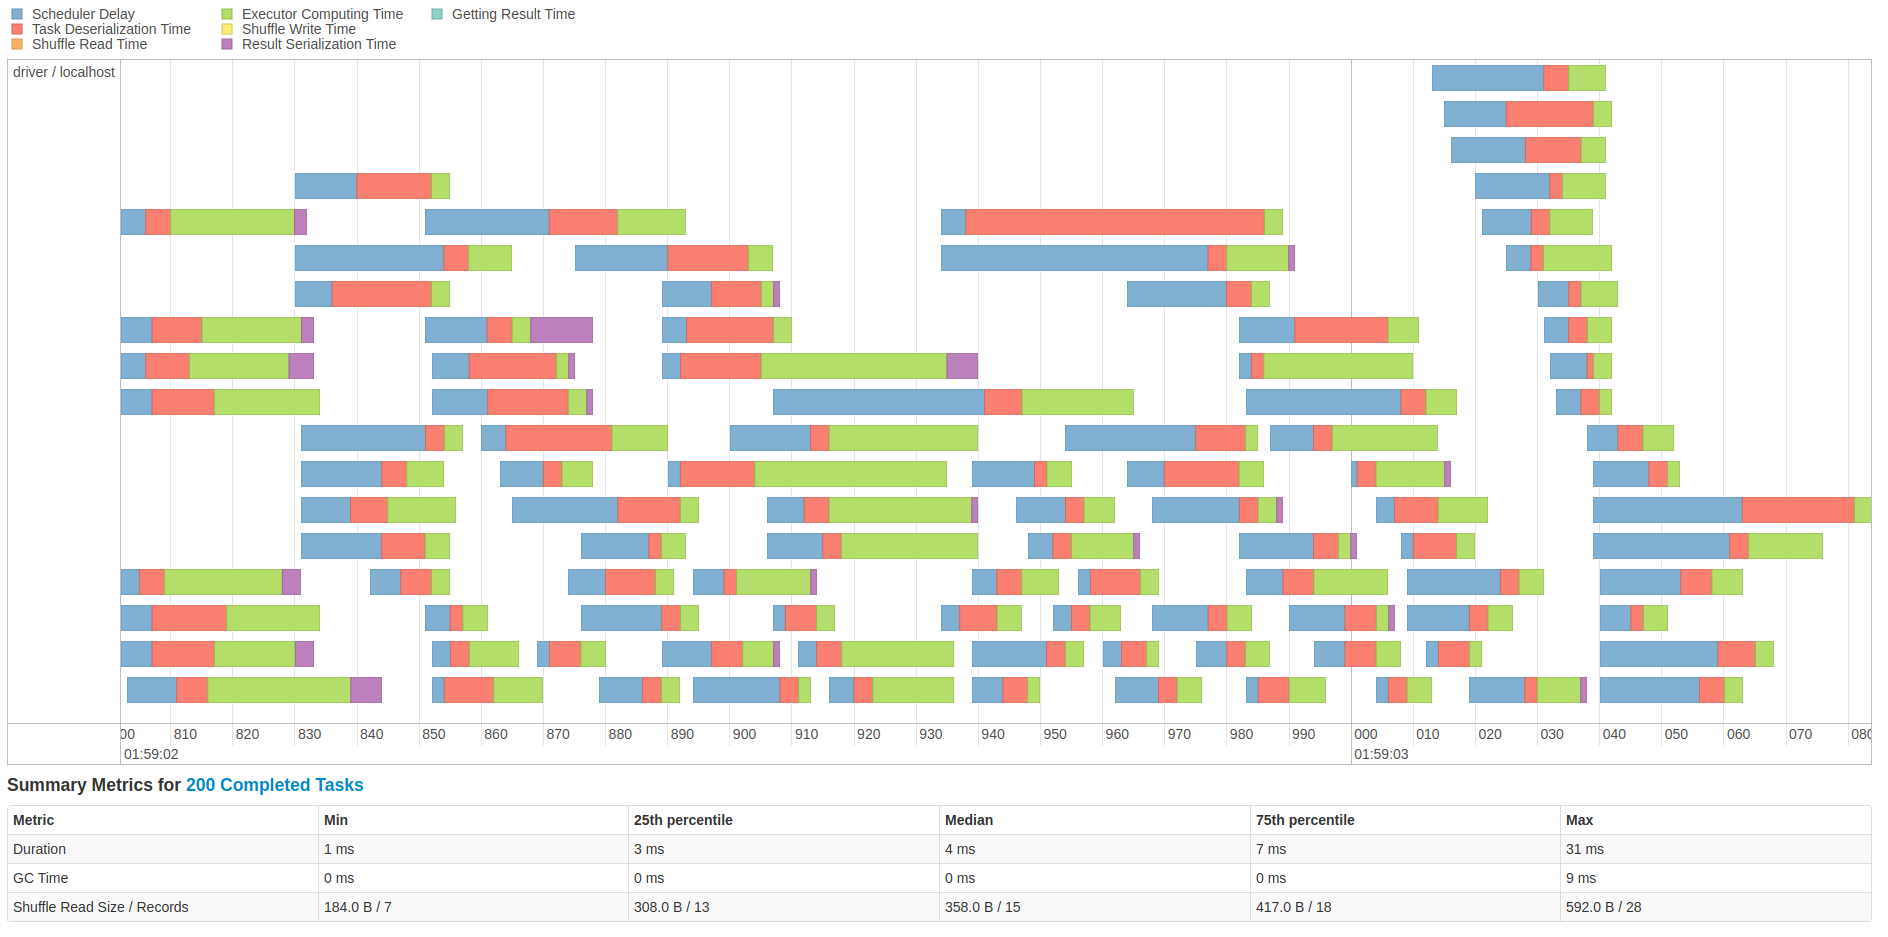

Olhando esse event timeline a gente consegue analisar, por exemplo, se as tasks estão "esperando" para serem inicializas, indicando que um aumento no número de nós poderia reduzir tempo de execução dessa task,

In [24]:
# Exemplo com muitas partições
repartition_n = df.repartition(400)

(repartition_n.select("nome", "qtde_nascimentos_ate_2010")
  .groupby("nome")
  .agg( sum("qtde_nascimentos_ate_2010")
        .alias("qtde_nascimentos_ate_2010"))
  .sort(col("qtde_nascimentos_ate_2010").desc())
  .limit(5).toPandas())


,nome,qtde_nascimentos_ate_2010
0,Maria,385816
1,Jose,163729
2,Ana,99245
3,Antonio,94619
4,Francisco,93829


Com um número muito grande de partições, o timeline do stage mostra muitas operações de shuffle

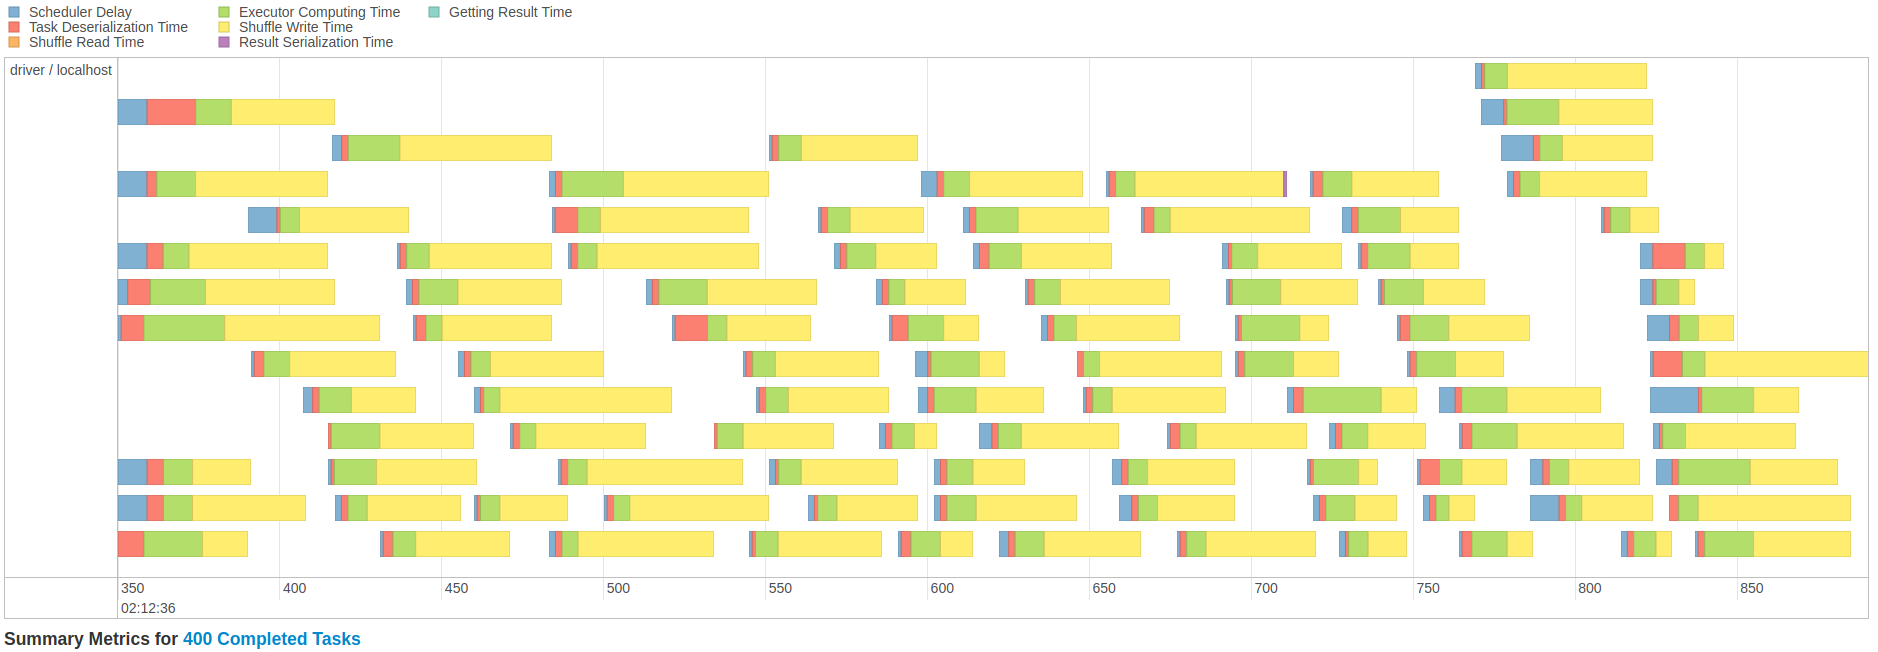

Comparando o tempo do Jobs:
Job 17 (sem repartition manual) =  0.6s \
Job 20 (com repartition de 400) = 3s
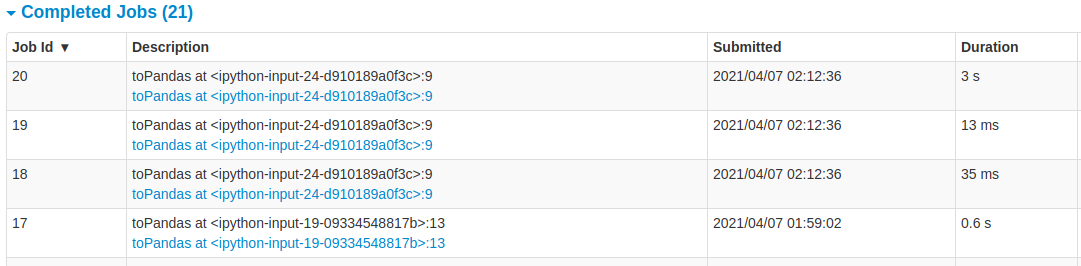

In [ ]:
# partição por chave de negócio
repartition_chave = df.repartition('nome')
print(f'Particionamento com chave de Negócio: {repartition_chave.rdd.getNumPartitions()}')

In [ ]:
# Dá pra ver os dados em cada partição
repartition_chave.rdd.glom().collect()[1]

In [ ]:
# Cuidado com as partições desbalanceadas
from matplotlib import pyplot
print(f"Estrutura do particionamento: ")

particoes_t = []
for i in repartition_chave.rdd.glom().collect():
    particoes_t.append(len(i))

pyplot.plot(range(0,len(particoes_t)),particoes_t)
#Cuidado com o data skew

## Cache
Pode ser usado quando um dataframe é utilizado várias vezes.

Caching is beneficial when we use particular RDD several times (and can slow down our calculations otherwise where the whole lineage graph will be processed several times).

O dataset fica em memória (ou também em disco) em todos os workers, cada nó persistindo sua partição e reutilizando em ações aplicadas naquele dataset

É equivalente ao método persist, com valor MEMORY_AND_DISK como localização.

Caching salva o data lineage, sendo útil caso seja necessário reconstruir os dados da base, caso algum nó do cluster caia.
 
Exemplo de count em dado com diferentes métodos de cache (fonte: https://towardsdatascience.com/apache-spark-caching-603154173c48):
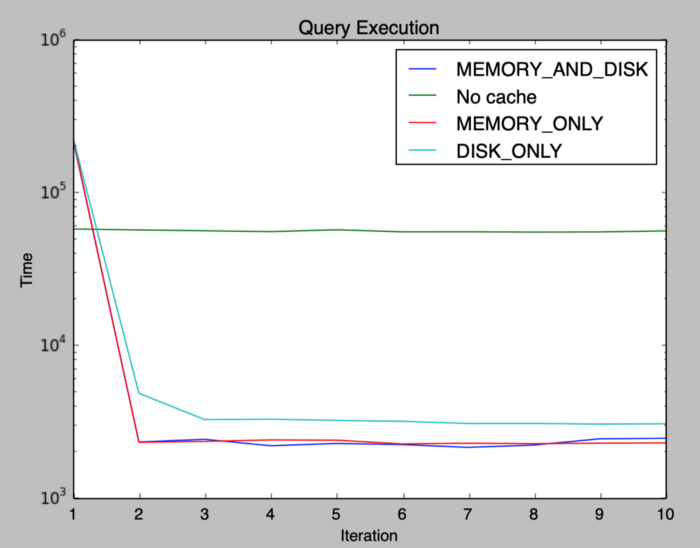


In [26]:
populacao.count() #Job 21

1000

In [30]:
# cache é lazy
populacao.cache()
populacao.count() #Job 22

1000

Aba Storage no Spark UI agora mostra o dataframe populacao
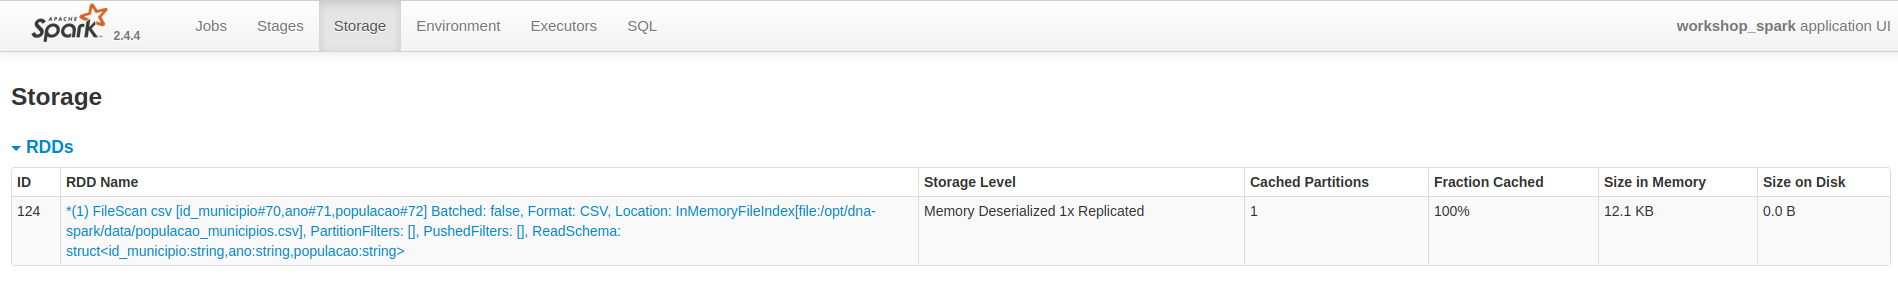

Comparação de tempo entre o count() em cima de um dataframe na chache (job 22) e sem cache (job 21)

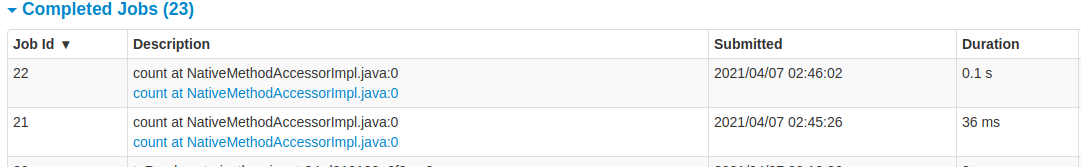

Detalhe do Stage do job usando cache (job 22), utiliza a operação InMemoryTableScan (ponto verde), que não acontece no stage do job sem cache (job 21)
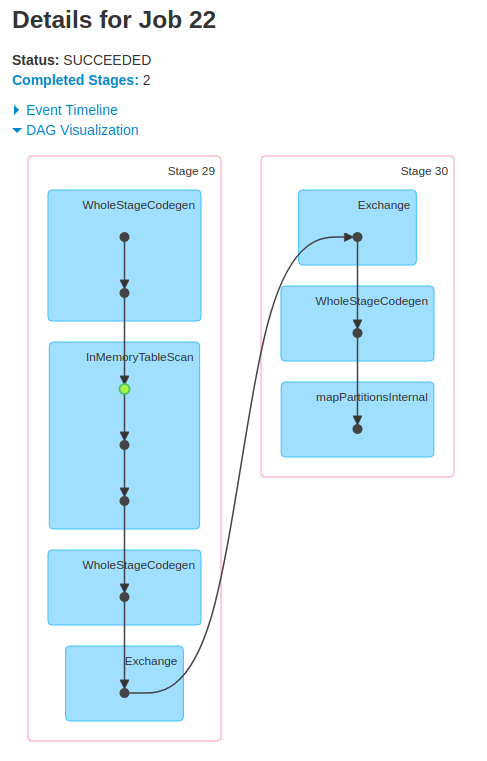

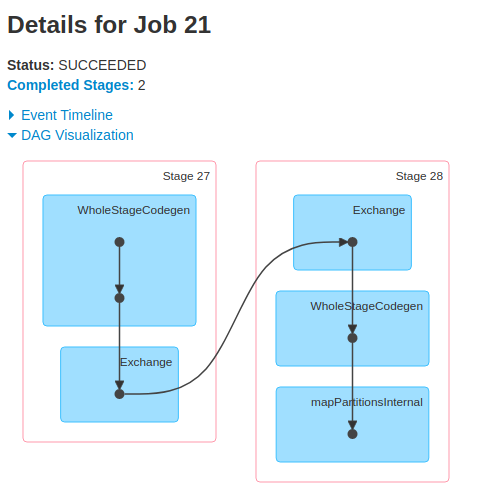

In [29]:
# Plano de ação se mantem
populacao.explain()

== Physical Plan ==
InMemoryTableScan [id_municipio#70, ano#71, populacao#72]
   +- InMemoryRelation [id_municipio#70, ano#71, populacao#72], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- *(1) FileScan csv [id_municipio#70,ano#71,populacao#72] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/opt/dna-spark/data/populacao_municipios.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<id_municipio:string,ano:string,populacao:string>


## Checkpoint

Salva checkpoint do Dataframe em disco, no diretório configurados em spark.sparkContext.setCheckpointDir().
Não mantém o plano de excução. O que pode ser ruim caso algum nó caia.

Broadcast vs cache
https://livebook.manning.com/book/spark-in-action-second-edition/16-cache-and-checkpoint-enhancing-spark-s-performances/v-14/22

Pode ser "lazy" ou "eager".

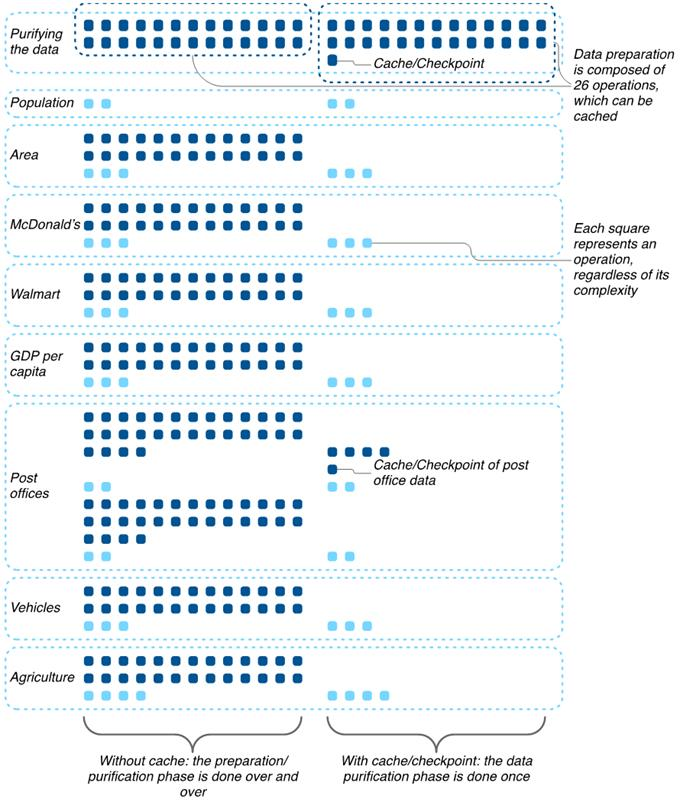

---
Artigo: https://medium.com/@adrianchang/apache-spark-checkpointing-ebd2ec065371

In [32]:
municipios.explain()
spark.sparkContext.setCheckpointDir('/checkpoints')

== Physical Plan ==
*(1) FileScan csv [id_municipio#10,id_municipio_6#11,id_municipio_TSE#12,id_municipio_RF#13,id_municipio_BCB#14,municipio#15,capital_estado#16,id_comarca#17,id_regiao_saude#18,regiao_saude#19,id_regiao_imediata#20,regiao_imediata#21,id_regiao_intermediaria#22,regiao_intermediaria#23,id_microrregiao#24,microrregiao#25,id_mesorregiao#26,mesorregiao#27,id_estado#28,estado_abrev#29,estado#30,regiao#31,existia_1991#32,existia_2000#33,existia_2010#34] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/opt/dna-spark/data/municipios.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<id_municipio:string,id_municipio_6:string,id_municipio_TSE:string,id_municipio_RF:string,i...


In [33]:
municipios_check = municipios.checkpoint()
municipios_check.count()
municipios_check.explain()

== Physical Plan ==
Scan ExistingRDD[id_municipio#10,id_municipio_6#11,id_municipio_TSE#12,id_municipio_RF#13,id_municipio_BCB#14,municipio#15,capital_estado#16,id_comarca#17,id_regiao_saude#18,regiao_saude#19,id_regiao_imediata#20,regiao_imediata#21,id_regiao_intermediaria#22,regiao_intermediaria#23,id_microrregiao#24,microrregiao#25,id_mesorregiao#26,mesorregiao#27,id_estado#28,estado_abrev#29,estado#30,regiao#31,existia_1991#32,existia_2000#33,existia_2010#34]


## UDF

User defined functions podem ser uteis para funções bem específicas, mas no geral, é melhor utilizar as funções spark!

https://www.google.com/url?sa=j&url=https%3A%2F%2Fpeople.eecs.berkeley.edu%2F~jegonzal%2Fpyspark%2Fpyspark.sql.html%3Fhighlight%3Dpyspark.sql.functions%23module-pyspark.sql.functions&uct=1578333168&usg=ztY89qe8Y24RjgQSqnPuKDp8A-c.&source=chat

In [34]:
@udf("string")
def lowercase(s):
    return s.lower()

print(nomes.withColumn("normalized", lowercase(col("nome"))).limit(1).toPandas())

  id_municipio    nome  qtde_nascimentos_ate_2010 normalized
0      1100015  Ademir                         46     ademir


In [35]:
print(nomes.withColumn("normalized", lower(col("nome"))).limit(1).toPandas())
# Ver diferença entre os jobs na dag e no tempo de execução, na UI

  id_municipio    nome  qtde_nascimentos_ate_2010 normalized
0      1100015  Ademir                         46     ademir


Comparação de tempo entre função lowercase criado em UDF e a utilização da função lowercase do spark:
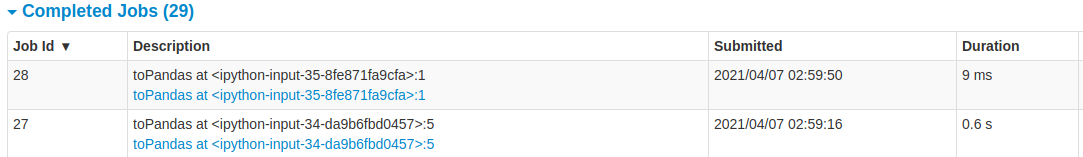

In [36]:
# No explainn tbm dá pra ver essa diferença de etapas. Focando no BatchEvalPython
nomes.withColumn("normalized", lowercase(col("nome"))).explain()

== Physical Plan ==
*(2) Project [id_municipio#86, nome#87, cast(qtde_nascimentos_ate_2010#88 as int) AS qtde_nascimentos_ate_2010#325, pythonUDF0#625 AS normalized#620]
+- BatchEvalPython [lowercase(nome#87)], [id_municipio#86, nome#87, qtde_nascimentos_ate_2010#88, pythonUDF0#625]
   +- *(1) FileScan csv [id_municipio#86,nome#87,qtde_nascimentos_ate_2010#88] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/opt/dna-spark/data/nomes_municipios.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<id_municipio:string,nome:string,qtde_nascimentos_ate_2010:string>


In [37]:
nomes.withColumn("normalized", lower(col("nome"))).explain()

== Physical Plan ==
*(1) Project [id_municipio#86, nome#87, cast(qtde_nascimentos_ate_2010#88 as int) AS qtde_nascimentos_ate_2010#325, lower(nome#87) AS normalized#626]
+- *(1) FileScan csv [id_municipio#86,nome#87,qtde_nascimentos_ate_2010#88] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/opt/dna-spark/data/nomes_municipios.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<id_municipio:string,nome:string,qtde_nascimentos_ate_2010:string>


## Nulls e NaNs

NaN = NaN returns true. \
In aggregations, all NaN values are grouped together. \
NaN is treated as a normal value in join keys. \
NaN values go last when in ascending order, larger than any other numeric value.

---
Doc: https://spark.apache.org/docs/3.0.0-preview/sql-ref-nan-semantics.html


In [12]:
nomes.withColumn("nome_null",col("nome").isNull()).toPandas()

,id_municipio,nome,qtde_nascimentos_ate_2010,nome_null
0,1100015,Ademir,46,False
1,1100015,Adriana,60,False
2,1100015,Aline,77,False
3,1100015,Amanda,51,False
4,1100015,Ana,300,False
...,...,...,...,...
15995,1500800,Vanda,189,False
15996,1500800,Vanderlei,63,False
15997,1500800,Vanderson,103,False
15998,1500800,Vanessa,1013,False


já que os dados são bons, vamos criar um dataframe fake para tratar os Nulls e NaNs

In [13]:
df_nan = spark.createDataFrame([(1.0, float('nan')), (float('nan'), 2.0),(None,3.0)], ("a", "b"))
df_nan.show()
df_nan.where(df_nan.a.isNull()).show()
df_nan.where(isnan(df_nan.a)).show()

+----+---+
|   a|  b|
+----+---+
| 1.0|NaN|
| NaN|2.0|
|null|3.0|
+----+---+

+----+---+
|   a|  b|
+----+---+
|null|3.0|
+----+---+

+---+---+
|  a|  b|
+---+---+
|NaN|2.0|
+---+---+



como fazer os tratamentos:

In [14]:
print(df_nan.toPandas())
print(df_nan.na.drop().toPandas())
df_nan.na.fill(0).toPandas()

     a    b
0  1.0  NaN
1  NaN  2.0
2  NaN  3.0
Empty DataFrame
Columns: [a, b]
Index: []


,a,b
0,1.0,0.0
1,0.0,2.0
2,0.0,3.0


## Window

---
Exemplo com imagem: https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html 

In [ ]:
populacao.count()
populacao_w = (populacao.withColumn("populacao_anterior",
                         lag(col("populacao")) 
                         .over(Window 
                               .partitionBy("id_municipio")
                               .orderBy("ano")
                              ) 
                         )
                         .withColumn("media_populacao_5_anos",
                                     avg(col("populacao"))
                                     .over(Window
                                           .partitionBy("id_municipio")
                                           .rowsBetween(0,4)
                                           .orderBy(desc("ano"))
                                          )
                                    )
                        .sort("id_municipio",desc("ano"))                        
              )
populacao_w.limit(5).toPandas()

## Referências

- https://luminousmen.com/post/hadoop-yarn-spark
- https://luminousmen.com/post/spark-tips-dataframe-api
- https://sparkbyexamples.com/
- https://spark.apache.org/docs/3.0.0-preview2/web-ui.html
- https://www.youtube.com/watch?v=daXEp4HmS-E&feature=youtu.be
- https://spark.apache.org/docs/latest/sql-performance-tuning.html
- https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html
- https://spark.apache.org/docs/3.0.0-preview/sql-ref-nan-semantics.html
- https://databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html
- https://www.tutorialdocs.com/article/spark-memory-management.html
- https://blog.scottlogic.com/2018/03/22/apache-spark-performance.html